# Introduction

This project is to make EDA and prediction on the Hong Kong Housing Price. We webscraped transaction data from Midland Property. We sampled 457 estates and 2245 residential buildings from the website. We also manually created new variables in the dataset including Distance from the nearest MTR station (DisMTR(km)), Distance from the CBD (DisCBD(km)), and if it is in Elite SchoolZone.

In [4]:
!pip install catboost

In [5]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns

Here we import precleaned and prefilled csv file for analysis

In [6]:
df = pd.read_csv('data2018_1.csv')

In [7]:
df

,Price(M),Floor,Area (Saleable),Trans Date,Age,Club,DisMTR(km),DisCBD(km),SchoolZone
0,1250,62,482,17/8/2018,17.67,1,1.00,13.8,0
1,1169,61,604,14/5/2018,17.67,1,1.00,13.8,0
2,864,59,604,16/5/2018,17.67,1,1.00,13.8,0
3,888,48,455,28/8/2018,17.67,1,1.00,13.8,0
4,770,41,451,7/2/2018,17.67,1,1.00,13.8,0
...,...,...,...,...,...,...,...,...,...
15387,600,37,354,15/10/2018,24.50,1,0.55,17.3,0
15388,728,31,578,6/7/2018,24.50,1,0.55,17.3,0
15389,808,22,578,16/8/2018,24.50,1,0.55,17.3,0
15390,600,21,413,5/7/2018,24.50,1,0.55,17.3,0


In [8]:
df1 = df.copy()

In [9]:
df1.describe()

,Price(M),Floor,Area (Saleable),Age,Club,DisMTR(km),DisCBD(km),SchoolZone
count,15392.000000,15392.000000,15392.000000,15392.000000,15392.000000,15392.000000,15392.000000,15392.000000
mean,939.905795,19.234213,568.589657,21.870824,0.738046,1.072369,17.561214,0.191593
std,966.727765,13.493344,247.560421,12.408104,0.439712,1.289750,11.103388,0.393567
min,126.000000,1.000000,121.000000,0.000000,0.000000,0.010000,2.200000,0.000000
25%,540.000000,9.000000,426.000000,13.500000,0.000000,0.350000,8.700000,0.000000
50%,703.000000,17.000000,511.000000,20.750000,1.000000,0.700000,13.800000,0.000000
75%,978.000000,27.000000,649.000000,31.670000,1.000000,1.500000,29.300000,0.000000
max,34400.000000,87.000000,3962.000000,59.750000,1.000000,9.200000,42.300000,1.000000


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15392 entries, 0 to 15391
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price(M)         15392 non-null  int64  
 1   Floor            15392 non-null  int64  
 2   Area (Saleable)  15392 non-null  int64  
 3   Trans Date       15392 non-null  object 
 4   Age              15392 non-null  float64
 5   Club             15392 non-null  int64  
 6   DisMTR(km)       15392 non-null  float64
 7   DisCBD(km)       15392 non-null  float64
 8   SchoolZone       15392 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 1.1+ MB


# Data cleaning

Here we will extract month from the `Trans Date` column, since there is peak season for housing transaction.

In [11]:
df1['Trans Date'] = pd.to_datetime(df1['Trans Date'])
df1['month'] = df1['Trans Date'].dt.month
df1.drop('Trans Date',axis=1, inplace=True)

Here we will visualize the distribution of the data

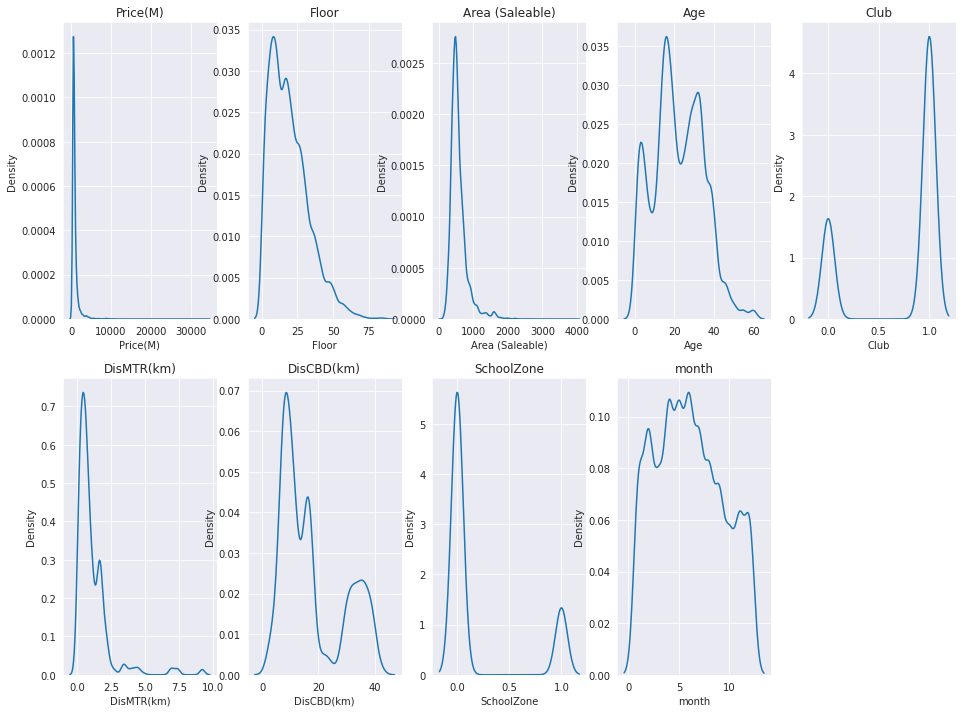

In [12]:
plt.figure(figsize=[16,12])
sns.set_style("darkgrid")

for i, col in zip(range(251,260), df1.columns):
    plt.subplot(i)
    sns.kdeplot(data=df1, x=col)
    plt.title(col)

In [13]:
print('kurtosis')
print(df1.kurtosis())
print('-'*50)
print('skewness')
print(df1.skew())

kurtosis
Price(M)           153.567111
Floor                0.962087
Area (Saleable)     10.844245
Age                 -0.505912
Club                -0.827489
DisMTR(km)          15.585337
DisCBD(km)          -0.863973
SchoolZone           0.456935
month               -0.996728
dtype: float64
--------------------------------------------------
skewness
Price(M)           8.417532
Floor              0.985219
Area (Saleable)    2.481992
Age                0.217062
Club              -1.082875
DisMTR(km)         3.518502
DisCBD(km)         0.769894
SchoolZone         1.567442
month              0.197909
dtype: float64


We can see our target variable is has high Kurtosis and skewness. Other variables also tend to skew to the left. We may need to normalize the data.

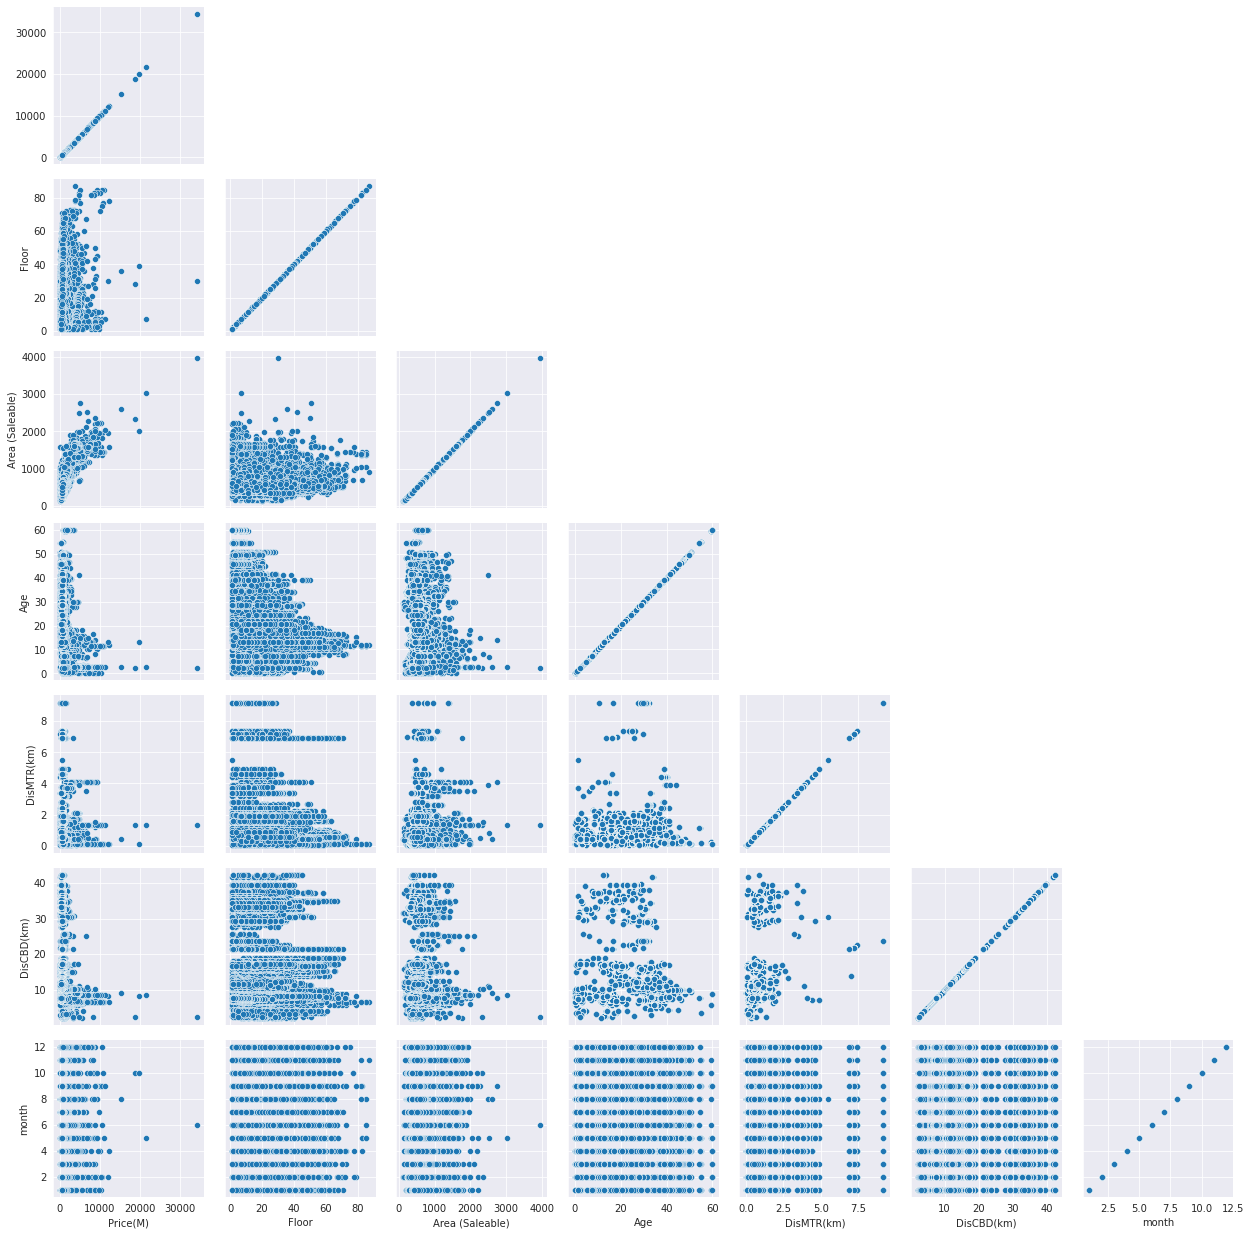

In [14]:
variables = ['Price(M)', 'Floor', 'Area (Saleable)', 'Age', 'DisMTR(km)',
       'DisCBD(km)',  'month']
g = sns.PairGrid(df1, diag_sharey=False, corner=True, vars=variables)
g.map(sns.scatterplot)

We can see there is only significant linear relationship between Price and Area. From the scatter plot we can't observe explicit relationship between Price and other variables

# Outlier Detection and Removal

We can see price and area are have some outliers from the scatter plot above and the boxplot below. We will remove those outliers to have a better model prediction.

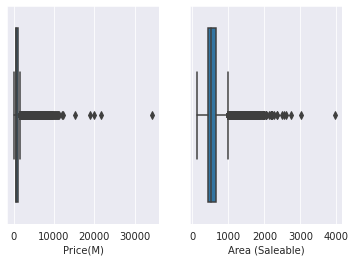

In [15]:
plt.subplot(121)
sns.boxplot(x='Price(M)', data=df1)

plt.subplot(122)
sns.boxplot(x='Area (Saleable)', data=df1)



In [36]:
from scipy.stats import zscore

In [17]:
lower_bound = -2.576
upper_bound = 2.576

df2 = df1[ ~ ((zscore(df1['Price(M)'])< lower_bound) | (zscore(df1['Price(M)']) > upper_bound) )]
df3 = df2[ ~ ((zscore(df2['Area (Saleable)'])< lower_bound) | (zscore(df2['Area (Saleable)']) > upper_bound) )]
df4 = df3[ ~ ((zscore(df3['Floor'])< lower_bound) | (zscore(df3['Floor']) > upper_bound) )]
df4 = df4.reset_index(drop=True)

In [18]:
df4

,Price(M),Floor,Area (Saleable),Age,Club,DisMTR(km),DisCBD(km),SchoolZone,month
0,888,48,455,17.67,1,1.00,13.8,0,8
1,770,41,451,17.67,1,1.00,13.8,0,7
2,930,40,566,17.67,1,1.00,13.8,0,5
3,833,38,451,17.67,1,1.00,13.8,0,1
4,788,33,451,17.67,1,1.00,13.8,0,2
...,...,...,...,...,...,...,...,...,...
14360,600,37,354,24.50,1,0.55,17.3,0,10
14361,728,31,578,24.50,1,0.55,17.3,0,6
14362,808,22,578,24.50,1,0.55,17.3,0,8
14363,600,21,413,24.50,1,0.55,17.3,0,5


# Detecting Multicollinearity

We can see there is no strong multicollinearity problem between variables

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# We only select independent variables to test multiconllinearity
check_mc_vars = df4.drop('Price(M)',axis = 1).columns
df_check_mc = df4[check_mc_vars]

#VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df_check_mc.columns
vif_data["VIF"] = [variance_inflation_factor(df_check_mc.values, i)
                          for i in range(len(df_check_mc.columns))]

print(vif_data)

           feature       VIF
0            Floor  3.191551
1  Area (Saleable)  8.860506
2              Age  3.503859
3             Club  4.396204
4       DisMTR(km)  1.825158
5       DisCBD(km)  4.109921
6       SchoolZone  1.436835
7            month  4.076664


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Variable relationship exploration

We will examine the correlation between the variable first. We can see there is no strong correlation between each variable. Month shows a very weak correlation with price and other variables.

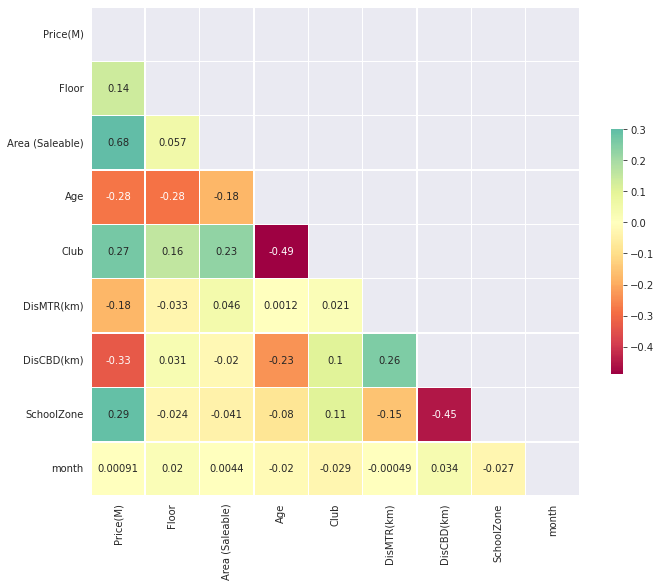

In [20]:
# Compute the correlation matrix
corr = df4.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("Spectral", as_cmap=True)
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Exploring relationships between variables

We band various variable for simpler visualization.

1. `Floor`: 
            0 : 0 to 5 
            1 : 5 to 10 
            2 : 10 to 15 
            3 : 15 to 20 
            4 : 20 to 30 
            5 : 30 to 90 
           
2. `Area (Saleable)`:
            0 : 100 to 200 
            1 : 200 to 300 
            2 : 300 to 400 
            3 : 400 to 500 
            4 : 500 to 600 
            5 : 600 to 700 
            6 : 700 to 800 
            7 : 800 to 900 
            8 : 900 to 1000 
            
3. `DisMTR(km)`:
            0 : 0 to 0.5 
            1 : 0.5 to 1 
            2 : 1 to 1.5 
            3 : 1.5 to 2 
            4 : 2 to 10 
            
4. `DisCBD(km)`:
            0 : 2.15 to 6.21
            1 : 6.21 to 10.21
            2 : 10.21 to 14.23
            3 : 14.23 to 18.24
            4 : 18.24 to 22.24
            5 : 22.24 to 26.25
            6 : 26.25 to 30.27
            7 : 30.27 to 34.28
            8 : 34.28 to 38.29
            9 : 38.29 to 42.3 
        
5. `Age` :
            0 : 0 to 5.975
            1 : 5.975 to 11.95
            2 : 11.95 to 17.92
            3 : 17.92 to 23.9
            4 : 23.9 to 29.875
            5 : 29.875 to 35.84
            6 : 35.84 to 41.82
            7 : 41.82 to 47.8
            8 : 47.8 to 53.775
            9 : 53.775 to 59.75


In [21]:
df4['Floor_bin'] = pd.cut(df4['Floor'], bins=[0,5,10,15,20,30,90], labels=[i for i in range(6)])
df4['Area_bin'] = pd.cut(df4['Area (Saleable)'], bins=[i for i in range(100,1100,100)],labels=[i for i in range(9)])
df4['DisMTR_bin'] = pd.cut(df4['DisMTR(km)'], bins=[0,0.5,1,1.5,2,10],labels=[i for i in range(5)])
df4['DisCBD_bin'] = pd.cut(df4['DisCBD(km)'], bins=10,labels=[i for i in range(10)])
df4['Age_bin'] = pd.cut(df4['Age'], bins=10,labels=[i for i in range(10)])

Age distribution

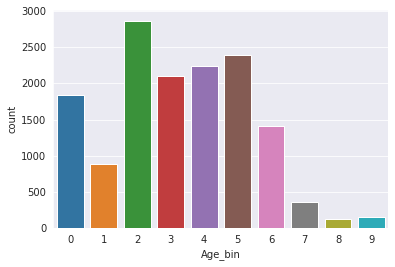

In [22]:
sns.countplot(x='Age_bin',data=df4)

Clubhouse Distribution

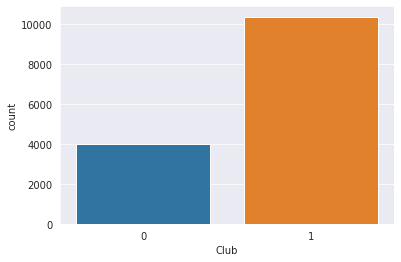

In [23]:
sns.countplot(x='Club',data=df4)

SchoolZone Distribution

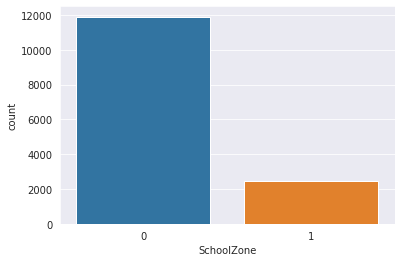

In [24]:
sns.countplot(x='SchoolZone',data=df4)

The flats with clubhouse tend to have a higher price in all price range

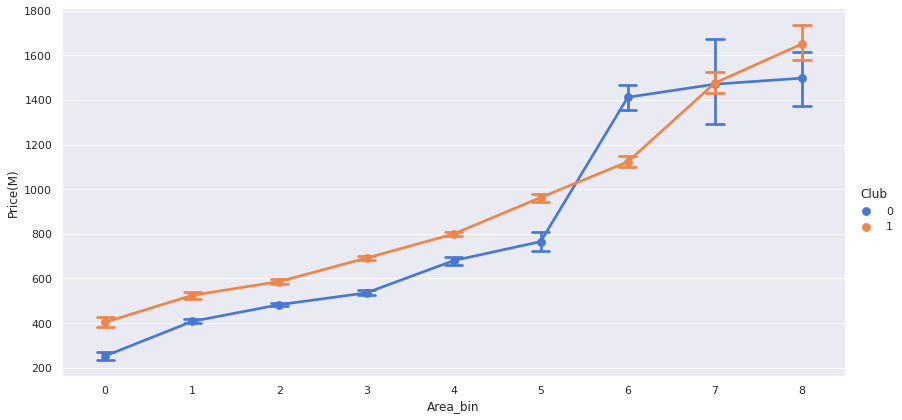

In [25]:
sns.set(rc={'figure.figsize':(20,12)})
PriceAreaClub_plot = sns.catplot(x='Area_bin', y="Price(M)", hue="Club",
                capsize=.2, palette="muted", height=6, aspect=2,
                kind="point", data=df4)

The buildings in SchoolZone tend to be more expensive.

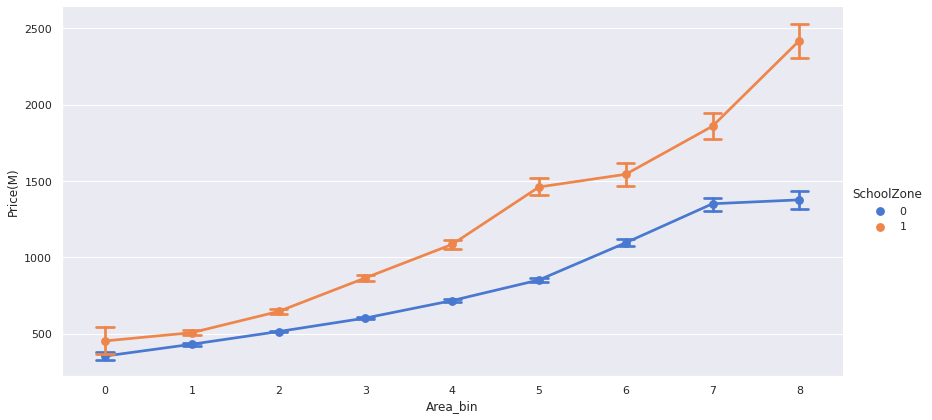

In [26]:
PriceSchool_plot = sns.catplot(x='Area_bin', y="Price(M)", hue="SchoolZone",
                capsize=.2, palette="muted", height=6, aspect=2,
                kind="point", data=df4)

The further the building from the CBD the lower the price is.

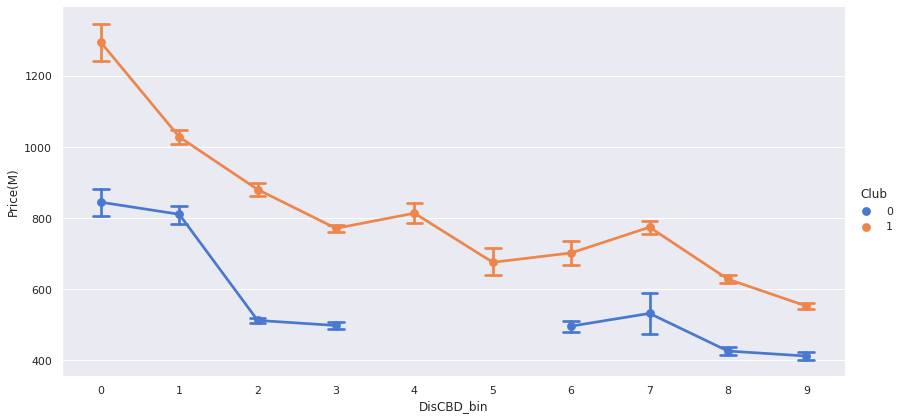

In [27]:
PriceAreaSchool_plot = sns.catplot(x='DisCBD_bin', y="Price(M)", hue="Club",
                capsize=.2, palette="muted", height=6, aspect=2,
                kind="point", data=df4)

The closer the building being near the MTR station does not necessarily imply higher price

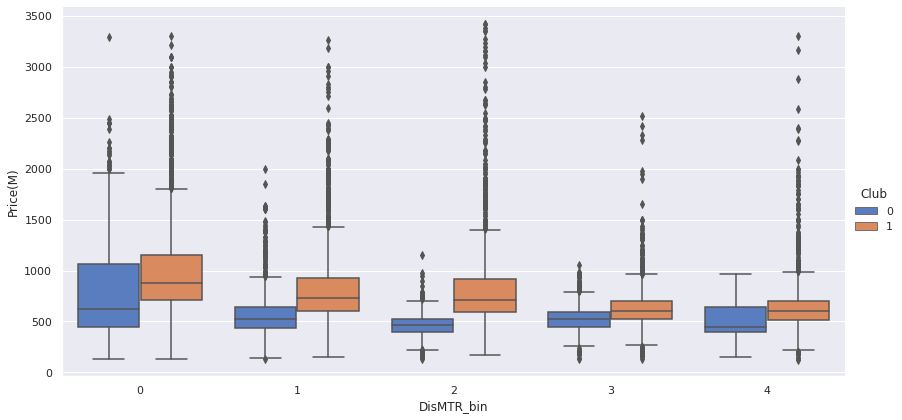

In [28]:
PriceDisMTR_plot = sns.catplot(x='DisMTR_bin', y="Price(M)", hue="Club",
                 palette="muted", height=6, aspect=2,
                kind="box", data=df4)

We can observe the Price, Age, Area relationship in this plot. The price tends to be higher with smaller age and larger area

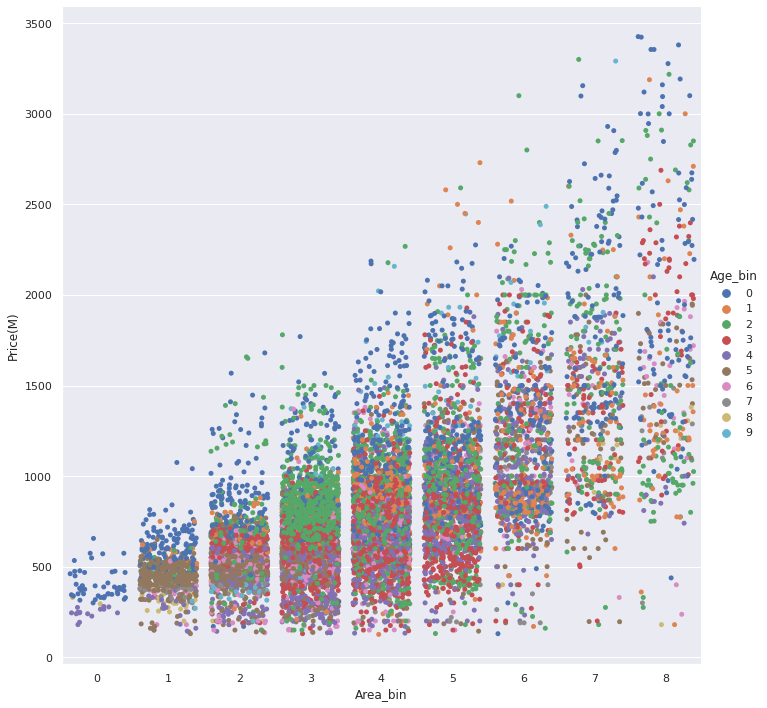

In [29]:
PriceAreaAge_plot = sns.catplot(x='Area_bin', y="Price(M)", hue="Age_bin", height=10, aspect=1,jitter=0.4,
            kind="strip", data=df4)

We can observe flats on a lower floor tends to have a higher price with the increase in area. However, when it comes to a higher floor, the difference in area does not neccessarily determine the price

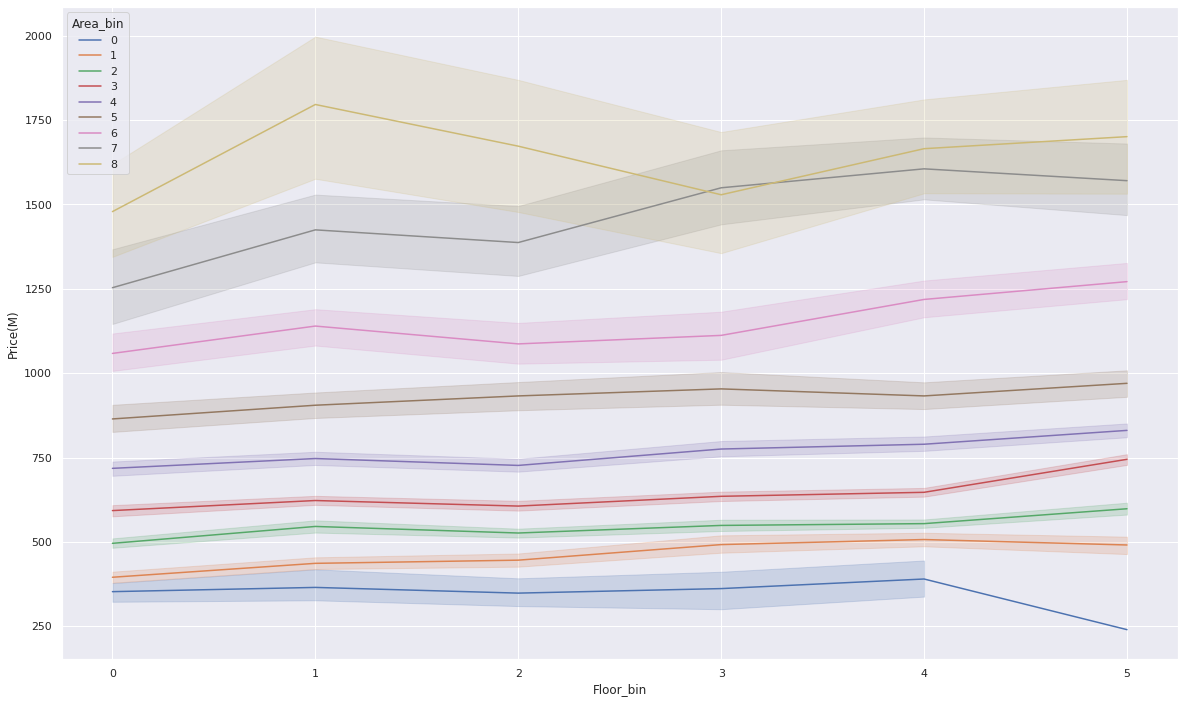

In [30]:
PriceFloorAge_plot = sns.lineplot(data=df4,x="Floor_bin", 
                                  y="Price(M)",hue="Area_bin")

# Data preprocessing for machine learning

In [37]:
# import sklearn librabries

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Lasso,Ridge,BayesianRidge,ElasticNet
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import ShuffleSplit,cross_val_score, GridSearchCV, train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


From the above, we saw `month` has a very low correlation with the price. Therefore we'll drop it in the model training. Now we will compare the model performance with scaling and without scaling using linear regression.

In [38]:
#df5 is the dataframe that we use to train the model
df5 = df4[['Price(M)', 'Floor', 'Area (Saleable)', 'Age', 'Club', 'DisMTR(km)',
       'DisCBD(km)', 'SchoolZone']].copy()

In [39]:
X=df5.drop(['Price(M)'],axis=1)
y=df5['Price(M)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [43]:
# Test the model with scaling of feature variables
lr = LinearRegression()
process_var = ['Floor', 'Area (Saleable)', 'Age', 'DisMTR(km)',
               'DisCBD(km)']
preprocessor = make_column_transformer((StandardScaler(),process_var))
pipe = make_pipeline(preprocessor, lr)

pipe.fit(X_train, y_train)
cross_val_score(pipe,X_test, y_test,scoring='neg_mean_squared_error').mean()

-51148.22693125909

In [44]:
# Test the model without scaling
lr.fit(X_train, y_train)
cross_val_score(lr,X_test, y_test,scoring='neg_mean_squared_error').mean()

-48487.28233809295

From the above, we can see the model performs slightly better without scaling the feature variables. Therefore, in the following, we will not scale the variables when testing other machine learning models.

# Initial training different ML algos

In [ ]:
ML_algos = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    BayesianRidge(), 
    ElasticNet(),
    XGBRegressor(),
    CatBoostRegressor()
    ]

MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Mean MSE']
MLA_df = pd.DataFrame(columns = MLA_columns)
MLA_predict = df5['Price(M)']


cv = ShuffleSplit(n_splits=5, test_size=0.2,random_state=100)

row_index = 0
for algo in ML_algos:
    MLA_name = algo.__class__.__name__
    MLA_df.loc[row_index, 'MLA Name'] = MLA_name
    MLA_df.loc[row_index, 'MLA Parameters'] = str(algo.get_params())
    
    cv_results = cross_val_score(algo, X, y, cv=cv, scoring='neg_mean_squared_error')
    MLA_df.loc[row_index, 'MLA Mean MSE'] = abs(cv_results.mean())
    
    row_index+=1
    
MLA_df.sort_values(by = ['MLA Mean MSE'], ascending = True, inplace = True)

In [46]:
MLA_df

,MLA Name,MLA Parameters,MLA Mean MSE
6,CatBoostRegressor,{'loss_function': 'RMSE'},18806.9
5,XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",24389.9
2,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",53799.8
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",53799.9
3,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_in...",53800.2
1,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",53810.1
4,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",56158.5


# Hyperparameter tuning

We can see CatboostRegressor and XGBRegressor outperform other classic regressors. We will just ensemble and train these two for our ultimate training model. We will use GridSearchCV to tune hyperparamenters to see if we can get a better score

In [ ]:
#Uncomment the following code to perform GridSearchCV
# tuning_algos = {        
#     'XGBRegressor' : {
#             'model': XGBRegressor(),
#             'params': {
#                 'n_estimators': [100, 300, 500,1000],
#                 'learning_rate': [0.01, 0.05, 0.1],
#                 'subsample': [0.5,0.8, 1],
#                 'max_depth': [2,3,5],
#                 'gamma' : [0, 1, 5]
#             }
#         },
#         'CatBoostRegressor': {
#             'model': CatBoostRegressor(),
#             'params': {
#                 'depth' : [3,6,8,10],
#                 'learning_rate' : [0.01, 0.05,0.1],
#                 'iterations'    : [100,200,500,1000],
#                 'loss_function': ['RMSE','MAE']
#             }
#         },
# }


# scores = []
# cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=100)
# for algo_name, config in tuning_algos.items():
#     gs =  GridSearchCV(config['model'], config['params'], cv=cv,n_jobs=-1,scoring='neg_mean_squared_error')
#     gs.fit(X,y) 
#     scores.append({
#         'model': algo_name,
#         'best_score': gs.best_score_,
#         'best_params': gs.best_params_
#     })

# tuning_algos_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
# tuning_algos_df

From the GridSearchCV, we found the best performing parameters for XGBRegressor and CatBoostRegressor.

1. XGBRegressor: 
   best_score : 19002 
   best_params: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}


2. CatBoostRegressor: 
   best_score : 18262
   best_params: {'depth': 10, 'iterations': 1000, 'learning_rate': 0.1, 'loss_function': 'MAE'}
   
We have increased the model accuracy by a little.

We will then ensemble two regressors to see if we can get a higher score

In [ ]:
vote_estimators = [
    ('cb', CatBoostRegressor(depth=10, iterations=1000, learning_rate=0.1, loss_function='MAE')),
    ('xgb',XGBRegressor(gamma=0, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8))
]

cv = ShuffleSplit(n_splits=5, test_size=0.2,random_state=100)
vr = VotingRegressor(estimators=vote_estimators)
vr_cv = cross_val_score(vr, X, y, cv=cv,scoring='neg_mean_squared_error').mean()

In [59]:
vr_cv

-18186.351762934624

We can see by ensembling our model MSE slightly dencreased. We will use this model as our final model. We will fit our model with training dataset and validate with the test set. We got 16636 for MSE

In [ ]:
vr.fit(X_train,y_train)

In [62]:
y_pred = vr.predict(X_test)
mean_squared_error(y_test,y_pred)

16636.25861904456

# Feature Importance plot
Here we will plot and see the importance of the features in different regressors in our model.

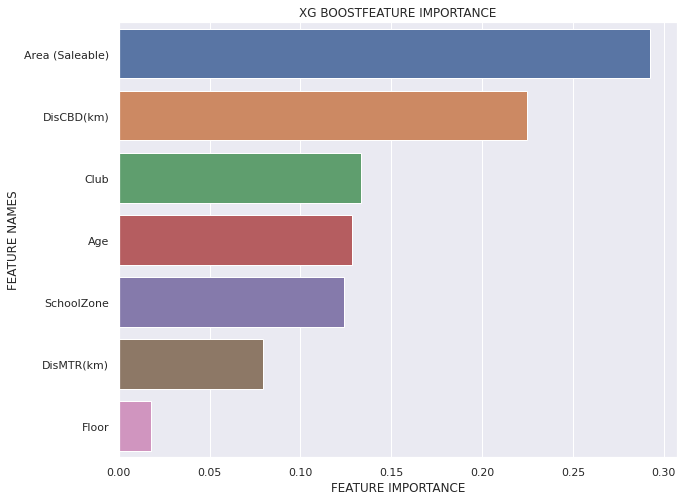

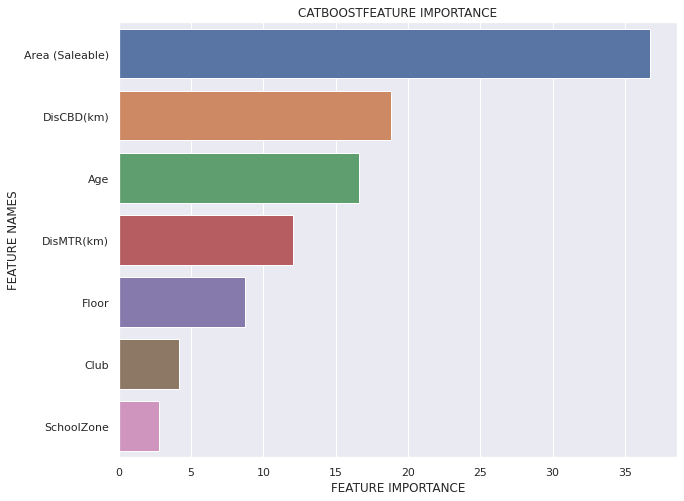

In [63]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(vr.estimators_[1].feature_importances_,X_train.columns,'XG BOOST')
plot_feature_importance(vr.estimators_[0].get_feature_importance(),X_train.columns,'CATBOOST')

# Testing our model and predicting

We will now predict the flat price in Hong Kong using real data from another website where we did not collect our dataset from (https://hk.centanet.com/). We will pick one from each district.

In [64]:
def predict_price(floor,area, age, club, DisMTR, 
                  DisCBD, SchoolZone):

    vars_list = [floor,area, age, club, DisMTR, 
                  DisCBD, SchoolZone]
    pred_df = pd.DataFrame(columns=X.columns)

    
    for variable, i in zip(vars_list,X.columns):
        pred_df.loc[0, i] = variable
        pred_df[i] = pred_df[i].astype(X.dtypes[i]) 
    
    pred_result = vr.predict(pred_df)
    
    return float(pred_result)
    

1.Belvedere Garden Phase 3 Block 5 14/F Flat A transacted on 2018-05-31 at HK$828(M)
https://hk.centanet.com/findproperty/transaction-detail/%E9%BA%97%E5%9F%8E%E8%8A%B1%E5%9C%92-3%E6%9C%9F_NJY202103R1444

In [65]:
predict_price(14,728,27.41,1,1.3,15.9,0)

836.6185809033055

2. Billionnaire Avant 18/F Flat C transacted on 2019-05-17 at HK$880(M)

https://hk.centanet.com/findproperty/transaction-detail/-_21042602090054

In [66]:
predict_price(18,465,4.58,1,1.2,9.3,1)

922.4121559041615

3. La Place de Victoria 41/F Flat Btransacted on 2018-10-18 at HK$2,100M
https://hk.centanet.com/findproperty/transaction-detail/-_21012200040095

In [67]:
predict_price(41,849,3,1,0.5,5.9,0)

2406.670002476466